In [480]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import re
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline

# Business Understanding

Here we use the Seattle and Boston AirBnB data to answer the following questions:

1. What are the most and least expensive times to rent in each city?
2. What are the most important features which drive the rental prices?  Are these different between the Seattle and Boston data?
3. Are there any strategies a potential renter may take to get a cheaper price on good properties?
4. Are the peak times of year in Seattle and Boston the same?


# Data Understanding

Here we get an overall understanding of the datasets, including:

1. Basic statistics
2. Number of missing values for each attribute
3. Distribution of key fields
4. Visual exploration of relationships between key attributes


### Data Import and Initial Cleanup

In [481]:
# Import the Boston data
bos_list = pd.read_csv('./Data/Boston/listings.csv')
bos_cal  = pd.read_csv('./Data/Boston/calendar.csv')
# bos_rev  = pd.read_csv('./Data/Boston/reviews.csv')

# Import the Seattle data
sea_list = pd.read_csv('./Data/Seattle/listings.csv')
sea_cal  = pd.read_csv('./Data/Seattle/calendar.csv')
# sea_rev  = pd.read_csv('./Data/Seattle/reviews.csv')

# Rename the 'id' field in the listing data to 'listing_id' to match the other tables
bos_list.rename(columns={'id':'listing_id'}, inplace=True)
sea_list.rename(columns={'id':'listing_id'}, inplace=True)

# Set indicies to the 'listing_id' on all dataframes
bos_list.set_index('listing_id', inplace=True)
bos_cal.set_index('listing_id', inplace=True)
# bos_rev.set_index('listing_id', inplace=True)

sea_list.set_index('listing_id', inplace=True)
sea_cal.set_index('listing_id', inplace=True)
# sea_rev.set_index('listing_id', inplace=True)

sea_cal.head()

,date,available,price,adjusted_price,minimum_nights,maximum_nights
listing_id,,,,,,
224763,2021-03-19,t,$159.00,$159.00,2.0,365.0
226536,2021-03-20,f,$41.00,$41.00,1.0,1125.0
226536,2021-03-21,f,$41.00,$41.00,1.0,1125.0
226536,2021-03-22,f,$41.00,$41.00,1.0,1125.0
226536,2021-03-23,f,$41.00,$41.00,1.0,1125.0


In [482]:
# Check to see if the Seattle and Boston listing datasets have the same columns
seattle_not_boston = list(set(sea_list.columns) - set(bos_list.columns))
boston_not_seattle = list(set(bos_list.columns) - set(sea_list.columns))

print("Columns in Seattle set but not in Boston set: ", seattle_not_boston)
print("Columns in Boston set but not in Seattle set: ", boston_not_seattle)

Columns in Seattle set but not in Boston set:  []
Columns in Boston set but not in Seattle set:  []


In [483]:
sea_list.columns

Index(['listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_updated',

In [484]:
# Drop columns not relevant to this analysis
cols_to_drop = ['listing_url', 'scrape_id', 'last_scraped', 'name', 
       'description', 'neighborhood_overview', 
       'picture_url',
       'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood', 
       'neighbourhood_group_cleansed', 'latitude', 'longitude',
       'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 
       'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'first_review', 'last_review', 
       'license', 'instant_bookable',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'calculated_host_listings_count',
       'reviews_per_month']

sea_list.drop(columns=cols_to_drop + seattle_not_boston, inplace=True)
bos_list.drop(columns=cols_to_drop + boston_not_seattle, inplace=True)

sea_list.head()

,host_is_superhost,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,...,calendar_updated,calendar_last_scraped,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
listing_id,,,,,,,,,,,,,,,,,,,,,
2318,f,Madrona,Entire house,Entire home/apt,9,NaN,2.5 baths,4.0,4.0,"[""Heating"", ""Kitchen"", ""Host greets you"", ""Ind...",...,NaN,2021-04-01,32,100.0,10.0,10.0,10.0,10.0,10.0,10.0
9419,t,Georgetown,Private room in apartment,Private room,2,NaN,3 shared baths,1.0,2.0,"[""Smoke alarm"", ""Patio or balcony"", ""Shampoo"",...",...,NaN,2021-03-19,148,93.0,10.0,10.0,10.0,10.0,10.0,10.0
9531,t,Fairmount Park,Entire house,Entire home/apt,4,NaN,1 bath,2.0,3.0,"[""TV"", ""Smoke alarm"", ""Patio or balcony"", ""Bar...",...,NaN,2021-03-20,41,100.0,10.0,10.0,10.0,10.0,10.0,10.0
9534,t,Fairmount Park,Entire guest suite,Entire home/apt,3,NaN,1 bath,2.0,2.0,"[""TV"", ""Smoke alarm"", ""Patio or balcony"", ""Bar...",...,NaN,2021-03-19,56,100.0,10.0,10.0,10.0,10.0,10.0,10.0
9596,f,Wallingford,Entire apartment,Entire home/apt,4,NaN,1 bath,1.0,4.0,"[""TV"", ""Smoke alarm"", ""Smart lock"", ""Patio or ...",...,NaN,2021-03-20,97,91.0,9.0,9.0,10.0,9.0,10.0,9.0


In [485]:
# Check for missing values in Seattle data
missing_vals = sea_list.isnull().sum().sort_values(ascending = False)
missing_vals[missing_vals > 0]

calendar_updated               4213
bathrooms                      4213
review_scores_value             773
review_scores_location          773
review_scores_communication     773
review_scores_checkin           773
review_scores_cleanliness       773
review_scores_accuracy          773
review_scores_rating            731
bedrooms                        573
host_is_superhost               192
beds                             36
bathrooms_text                    5
dtype: int64

In [486]:
# Check for missing values in Boston data
missing_vals = bos_list.isnull().sum().sort_values(ascending = False)
missing_vals[missing_vals > 0]

calendar_updated               2934
bathrooms                      2934
review_scores_checkin           840
review_scores_value             839
review_scores_location          839
review_scores_accuracy          839
review_scores_cleanliness       838
review_scores_communication     837
review_scores_rating            837
bedrooms                        366
host_is_superhost                64
beds                             41
bathrooms_text                    5
dtype: int64

In [487]:
# Convert boolean string fields to boolean
sea_list.replace({'host_is_superhost': {'t': True, 'f': False}}, inplace=True)
bos_list.replace({'host_is_superhost': {'t': True, 'f': False}}, inplace=True)

sea_cal.replace({'available': {'t': True, 'f': False}}, inplace=True)
bos_cal.replace({'available': {'t': True, 'f': False}}, inplace=True)

In [488]:
# Convert date fields to DateTime64
bos_cal.date = pd.to_datetime(bos_cal.date)
bos_rev.date = pd.to_datetime(bos_rev.date)

sea_cal.date = pd.to_datetime(sea_cal.date)
sea_rev.date = pd.to_datetime(sea_rev.date)

In [489]:
# Convert price fields to float
bos_cal.price = bos_cal.price.str.replace('[^\d\.]','', regex=True).astype('float')
sea_cal.price = sea_cal.price.str.replace('[^\d\.]','', regex=True).astype('float')

# bos_list.price = bos_list.price.str.replace('[^\d\.]','', regex=True).astype('float')
# sea_list.price = sea_list.price.str.replace('[^\d\.]','', regex=True).astype('float')

# sea_list.extra_people = sea_list.extra_people.str.replace('[^\d\.]','', regex=True).astype('float')
# bos_list.extra_people = bos_list.extra_people.str.replace('[^\d\.]','', regex=True).astype('float')

### Exploratory Data Analysis

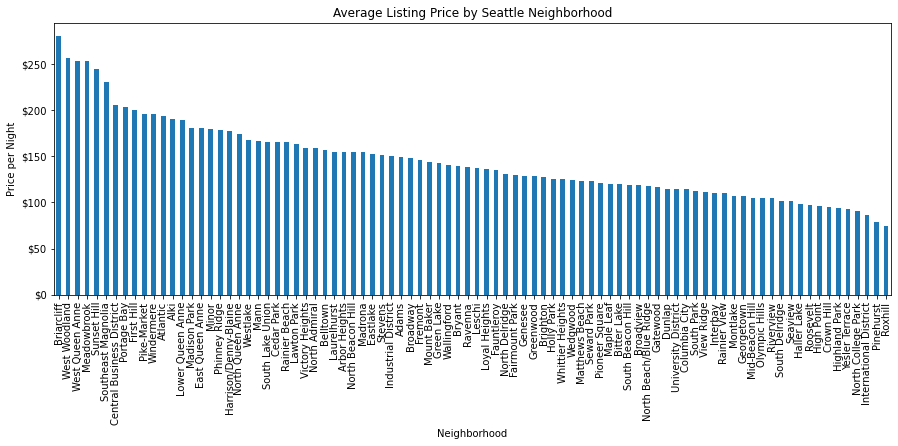

In [490]:
fig, ax = plt.subplots(1, 1, figsize=(15,5))

_ = sea_cal.join(sea_list[['neighbourhood_cleansed']]) \
       .reset_index() \
       .groupby('neighbourhood_cleansed') \
       .price.mean() \
       .sort_values(ascending=False) \
       .plot(kind='bar', ax=ax)

_ = plt.title("Average Listing Price by Seattle Neighborhood")
_ = plt.xlabel("Neighborhood")
_ = plt.ylabel("Price per Night")

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 

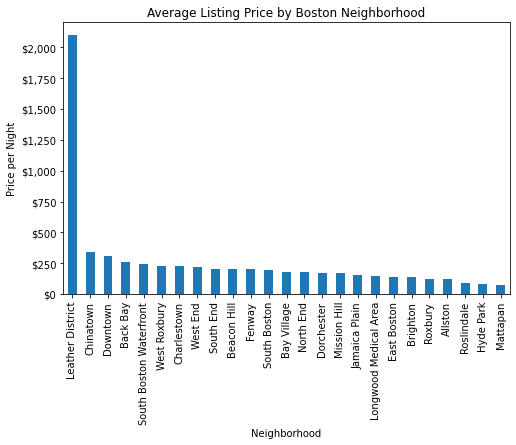

In [491]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))

_ = bos_cal.join(bos_list[['neighbourhood_cleansed']]) \
       .reset_index() \
       .groupby('neighbourhood_cleansed') \
       .price.mean() \
       .sort_values(ascending=False) \
       .plot(kind='bar', ax=ax)

_ = plt.title("Average Listing Price by Boston Neighborhood")
_ = plt.xlabel("Neighborhood")
_ = plt.ylabel("Price per Night")

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 

In [492]:
print('Seattle date range: ', sea_cal.date.min().strftime('%Y-%m-%d'), ' to ', sea_cal.date.max().strftime('%Y-%m-%d'))
print('Boston date range : ', bos_cal.date.min().strftime('%Y-%m-%d'), ' to ', bos_cal.date.max().strftime('%Y-%m-%d'))

Seattle date range:  2021-03-18  to  2022-04-05
Boston date range :  2021-03-12  to  2022-03-31


In [493]:
# Make sure date ranges line up between Boston and Seattle
bos_cal = bos_cal[(bos_cal.date > '2021-03-18') & (bos_cal.date < '2022-03-15')]
sea_cal = sea_cal[sea_cal.date < '2022-03-15']

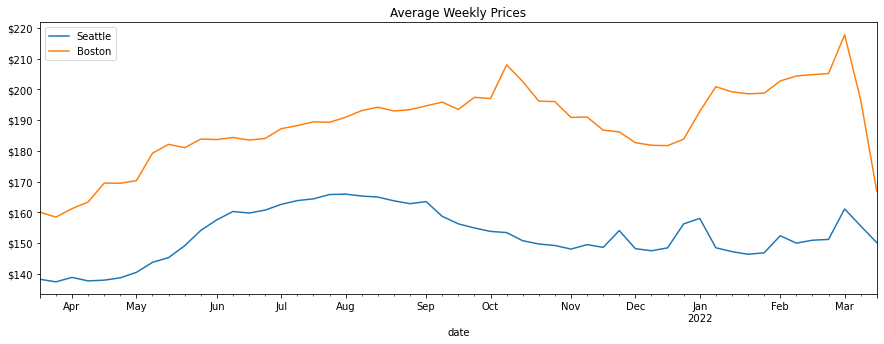

In [497]:
fig, ax = plt.subplots(1, 1, figsize=(15,5))

_ = sea_cal \
       .resample('W', on='date') \
       .price.mean() \
       .plot(label='Seattle', ax=ax)

_ = bos_cal \
       .resample('W', on='date') \
       .price.mean() \
       .plot(label='Boston', ax=ax)

_ = plt.title('Average Weekly Prices')
_ = plt.legend()

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 

Looks like the Boston Marathon spikes prices!  For Seattle, summer is higher as well as Thanksgiving and Christmas.

In [495]:
sea_cal['month'] = sea_cal.date.dt.month
bos_cal['month'] = bos_cal.date.dt.month

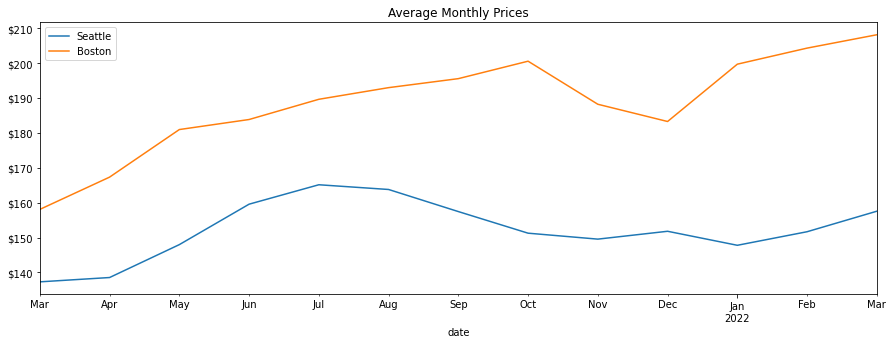

In [496]:
fig, ax = plt.subplots(1, 1, figsize=(15,5))

_ = sea_cal \
       .resample('M', on='date') \
       .price.mean() \
       .plot(label='Seattle', ax=ax)

_ = bos_cal \
       .resample('M', on='date') \
       .price.mean() \
       .plot(label='Boston', ax=ax)

_ = plt.title('Average Monthly Prices')
_ = plt.legend()

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 